In [1]:
import sys
sys.path.append('../../pybeh')
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import cmlreaders as cml
from SimulatedSubjectData import *
from pandas_to_pybeh import pd_crp, get_all_matrices
import matplotlib.pyplot as plt
import pickle
pd.set_option("display.max_columns", None)
import os
import cmldask.CMLDask as da
import cmldask
from dask.distributed import wait, as_completed, progress
from dask import delayed, compute
import logging
import glob
import seaborn as sns

In [2]:
list_len = 15
num_lists = 1000

exp = 'CourierReinstate1'
subjects = ['LTP564', 'LTP565', 'LTP566', 'LTP567', 'LTP568', 'LTP569', 'LTP571', 'LTP572', 'LTP573',
            'LTP574', 'LTP575', 'LTP576', 'LTP577', 'LTP578', 'LTP579', 'LTP580', 'LTP581', 'LTP583',
            'LTP584', 'LTP585', 'LTP586', 'LTP587', 'LTP588', 'LTP589', 'LTP590', 'LTP591', 'LTP592', 
            'LTP593', 'LTP594', 'LTP595', 'LTP596', 'LTP597', 'LTP598', 'LTP599', 'LTP600', 'LTP601', 
            'LTP602', 'LTP603', 'LTP604', 'LTP605']

In [3]:
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Dictionary saved to {filename}")

def load_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
df = cml.get_data_index('ltp', rootdir='/').query("experiment == @exp")

full_evs = None
for i, row in df.iterrows():
    reader = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'])
    evs = reader.load('task_events')
    full_evs = evs if full_evs is None else pd.concat([full_evs, evs], ignore_index=True)
full_evs = full_evs.query("subject in @subjects")
full_evs = full_evs[(full_evs['item'] != "AMPLIFIER") & (full_evs['item'] != "APPLE") & (full_evs['item'] != "AXE") & 
                    (full_evs['item'] != "BASKETBALL_HOOP") & (full_evs['item'] != "DOOR") & (full_evs['item'] != "IRONING_BOARD") & 
                    (full_evs['item'] != "SHOVEL") & (full_evs['item'] != "STOVE")]

In [5]:
with open("words.pkl", "rb") as f:
    wordpool = pickle.load(f)

In [6]:
def compute_recall_rate(data):
    word_evs = data[data['type'] == 'WORD']
    return word_evs['recalled'].sum() / len(word_evs)

def compute_first_recall(data, list_len):
    rec_evs = data[data['type'] == 'REC_WORD']
    rec_evs['pos'] = rec_evs.groupby(['session', 'trial']).cumcount()
    first_recall_df = rec_evs.query('pos == 0 and serialpos >= 0')
    first_recall_df = first_recall_df.groupby(
        ['serialpos']).agg(
        {'recalled': 'count'}).reindex(range(1, list_len+1), fill_value=0)
    n_lists = first_recall_df['recalled'].sum()
    return first_recall_df['recalled'].to_numpy(dtype=float) / n_lists

def compute_lag_crp_single_subject_array(
    data, 
    list_len
):
    center = list_len - 1
    min_lag = -center
    max_lag = center + 1
    actual = {lag: 0 for lag in range(min_lag, max_lag)}
    possible = {lag: 0 for lag in range(min_lag, max_lag)}
    for session_id, session_data in data.groupby('session'):
        recalls = session_data[session_data.type == 'REC_WORD']
        # print(recalls)
        words = session_data[session_data.type == 'WORD']
        if recalls.empty or words.empty:
            print(f"session {session_id} has no events")
            continue
        # print(recalls.intruded)
        recalls = recalls[(recalls['trial'] != -999)]
        word_to_pos = dict(zip(words['item'], words['serialpos']))
        # print(word_to_pos)
        # print(recalls)
        for trial in recalls['trial'].unique():
            trial_words = words[words['trial'] == trial]['item'].tolist()
            trial_recalls = (recalls[recalls['trial'] == trial]
                             .sort_values('rectime')
                             .drop_duplicates('item'))
            
            if len(trial_recalls) < 2:
                print(f"session {session_id}, trial {trial} doesn't have enough events")
                continue
            trial_recalls = trial_recalls[trial_recalls['item'].isin(trial_words)]
            recall_pos = [word_to_pos[w] for w in trial_recalls['item']]
            # print(recall_pos)
            for i, cur in enumerate(recall_pos[:-1]):
                lag = recall_pos[i+1] - cur
                if min_lag <= lag <= max_lag and lag != 0:
                    actual[lag] += 1
                for pos in set(range(1, list_len+1)) - set(recall_pos[:i+1]):
                    pl = pos - cur
                    if min_lag <= pl <= max_lag and pl != 0:
                        possible[pl] += 1

    # build CRP array
    full_len = 2*list_len - 1
    crp = np.full(full_len, np.nan)
    center = list_len - 1
    for lag in range(min_lag, max_lag):
        idx = center + lag
        if 0 <= idx < full_len:
            crp[idx] = (actual[lag] / possible[lag]) if possible[lag] > 0 else np.nan
    crp[center] = 0.0
    return crp

In [7]:
# CourierReinstate1 data
sub_parameters = {}

for sub in subjects:
    df_sub = full_evs[full_evs['subject'] == sub]
    recall_rate = compute_recall_rate(df_sub)
    first_recall = compute_first_recall(df_sub, list_len)
    lag_crp = compute_lag_crp_single_subject_array(df_sub, list_len)
    sub_parameters[sub] = {
        'recall_rate': recall_rate,
        'first_recall': first_recall,
        'lag_crp': lag_crp
    }

session 2, trial 7 doesn't have enough events


In [8]:
def load_all_subjects_optimized(folder):
    """
    Loads all {subject}_optimized.pkl files in the folder and combines them into a single dictionary.
    """
    all_data = {}
    # find all files ending with _optimized.pkl
    files = glob.glob(os.path.join(folder, "*_optimized.pkl"))
    
    for file in files:
        with open(file, 'rb') as f:
            subject_data = pickle.load(f)  # this is a single dict like {'LTP564': {...}}
            # merge into all_data
            all_data.update(subject_data)
    
    return all_data

In [9]:
subj_optimized = load_all_subjects_optimized('Optimization_Results')

In [10]:
# Simulated data
len_lists = 15
num_lists = 100
sim_dfs = {}

for sub, parameters in sub_parameters.items():
    best_lag_crp = subj_optimized[sub]['best_lag_crp']
    # print(best_lag_crp)
    sim = SimulatedSubjectData(
        subject=sub,
        first_recall=parameters['first_recall'],
        lag_crp=best_lag_crp,
        recall_rate=parameters['recall_rate'],
        value_acc=0.6
    )
    df_sim = sim.generateData(list_len, num_lists, wordpool=wordpool, gen_pos=True)
    sim_dfs[sub] = df_sim

In [11]:
os.makedirs("sim_data", exist_ok=True)
for sub, df in sim_dfs.items():
    df.to_pickle(f"sim_data/{sub}.pkl")
full_evs_sim = pd.concat([pd.read_pickle(p) for p in glob.glob("sim_data/*.pkl")], ignore_index=True)

In [13]:
# Recall probability per subject
pres = full_evs_sim.type=='WORD'
recall_by_sub = full_evs_sim[pres].groupby('subject')\
    .agg({'recalled':'mean'})\
    .rename(columns={"recalled":"Recall Probability"}
)
recall_by_sub = recall_by_sub.reset_index()
recall_by_sub = recall_by_sub.sort_values(by="Recall Probability", ascending=True)
sub_recall = recall_by_sub.subject.values
recall_by_sub

,subject,Recall Probability
30,LTP596,0.291333
5,LTP569,0.359333
4,LTP568,0.409333
31,LTP597,0.442000
33,LTP599,0.446667
39,LTP605,0.472000
3,LTP567,0.521333
14,LTP579,0.524000
10,LTP575,0.547333
38,LTP604,0.564000


In [14]:
# Overall recall probability
print(f"Mean = {recall_by_sub['Recall Probability'].mean()}, SD = {recall_by_sub['Recall Probability'].std()}")

Mean = 0.7118833333333333, SD = 0.17711739873449173


In [15]:
# Serial position curve
spc_df = full_evs_sim.query("type=='WORD'").groupby(
    ['subject', 'session', 'serialpos']
).agg({'recalled':np.nanmean}).reset_index()

avg_spc_df = spc_df.groupby(["subject","serialpos"]).agg({"recalled":"mean"}).reset_index()
avg_spc_df

,subject,serialpos,recalled
0,LTP564,1,0.723232
1,LTP564,2,0.738889
2,LTP564,3,0.652525
3,LTP564,4,0.729394
4,LTP564,5,0.710101
...,...,...,...
595,LTP605,11,0.538283
596,LTP605,12,0.549192
597,LTP605,13,0.517677
598,LTP605,14,0.468283


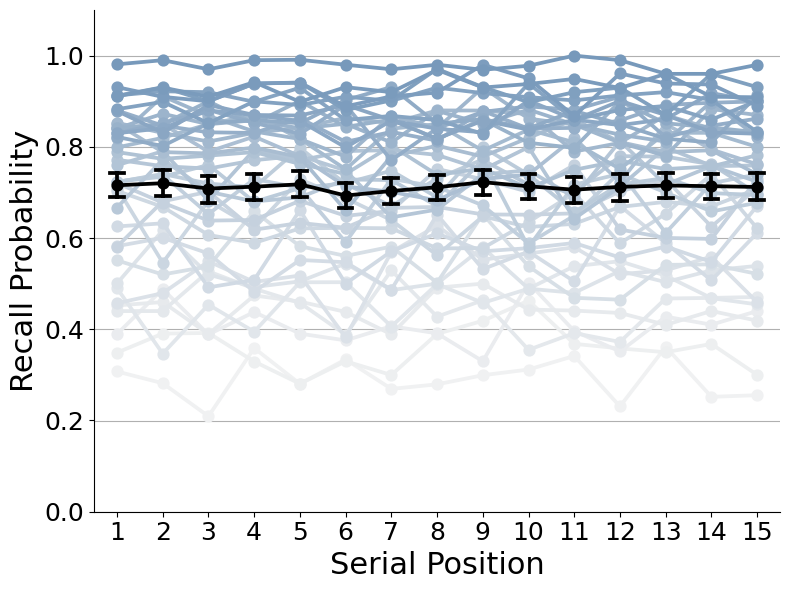

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_df = avg_spc_df.query('subject == @sub')
    sub_spc = sns.pointplot(data=sub_df, x='serialpos', y='recalled', ci=None, ax=ax, color=colors[i])
    
spc = sns.pointplot(data=avg_spc_df, x='serialpos', y='recalled', ci=68, capsize=.3, ax=ax, color="k")

plt.xlabel('Serial Position', fontsize=22)
plt.ylabel('Recall Probability', fontsize=22)
plt.tick_params(labelsize=18)
plt.ylim(0, 1.1)
spc.yaxis.grid()
plt.tight_layout()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.show()

In [17]:
# Probability of first recall
recword = full_evs_sim.query('type=="REC_WORD"')
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
first_recall_df = recword.query('pos == 0 and serialpos >= 0')
first_recall_df = first_recall_df.groupby(
    ['subject', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_df['n_lists'] = first_recall_df.groupby(['subject'])['recalled'].transform('sum')
first_recall_df['prob'] = first_recall_df['recalled'] / first_recall_df['n_lists']
first_recall_df

,subject,serialpos,recalled,n_lists,prob
0,LTP564,1,67,100,0.67
1,LTP564,2,23,100,0.23
2,LTP564,3,4,100,0.04
3,LTP564,4,0,100,0.00
4,LTP564,5,2,100,0.02
...,...,...,...,...,...
595,LTP605,11,0,100,0.00
596,LTP605,12,1,100,0.01
597,LTP605,13,0,100,0.00
598,LTP605,14,0,100,0.00


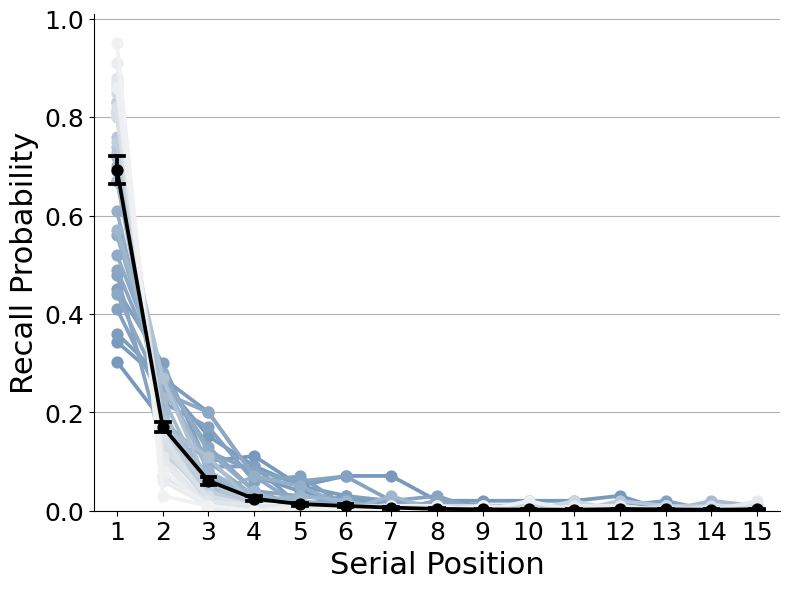

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_df = first_recall_df.query('subject == @sub')
    sub_spc = sns.pointplot(data=sub_df, x='serialpos', y='prob', ci=None, ax=ax, color=colors[len(colors)-i-1])

spc = sns.pointplot(data=first_recall_df, x='serialpos', y='prob', ci=68, capsize=.3, ax=ax, color="k")

plt.xlabel('Serial Position', fontsize=22)
plt.ylabel('Recall Probability', fontsize=22)
plt.tick_params(labelsize=18)
plt.ylim(0, 1.01)
plt.tight_layout()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
spc.yaxis.grid()
plt.show()

In [19]:
# Lag CRP
rec_word_types_all = ['REC_WORD', 'REC_WORD_VV']
present_types = set(full_evs['type'].unique())
present_rec_types = [t for t in rec_word_types_all if t in present_types]

need_types = ['WORD'] + present_rec_types
clean_evs = full_evs_sim[full_evs_sim['type'].isin(need_types)].copy()

for t in present_rec_types:
    if t != 'REC_WORD':
        clean_evs.loc[clean_evs['type'] == t, 'type'] = 'REC_WORD'

is_word = clean_evs['type'].eq('WORD')
is_rec  = clean_evs['type'].eq('REC_WORD')

temporal_evs = clean_evs[~is_word].copy()
temporal_evs

,experiment,item,itemno,item_val,trial,rectime,recalled,recallpos,serialpos,subject,type,val_list_avg,val_guess,pos_x,pos_y,session
1500,VCsim,basil,493,26,0,0,1,5,1,LTP564,REC_WORD,20.733333,15,0.942189,0.682026,0
1501,VCsim,pearls,630,22,0,0,1,7,2,LTP564,REC_WORD,20.733333,15,0.658328,0.724372,0
1502,VCsim,pizza_box,398,21,0,0,1,4,7,LTP564,REC_WORD,20.733333,15,0.287775,0.579191,0
1503,VCsim,nails,377,23,0,0,1,8,8,LTP564,REC_WORD,20.733333,15,0.284627,0.980282,0
1504,VCsim,aspirin,10,16,0,0,1,2,9,LTP564,REC_WORD,20.733333,15,0.367996,0.096115,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102708,VCsim,hangers,108,32,99,99,1,3,3,LTP605,REC_WORD,34.800000,15,0.666861,0.605969,9
102709,VCsim,doughnut,547,32,99,99,1,1,5,LTP605,REC_WORD,34.800000,15,0.665060,0.031237,9
102710,VCsim,jacket,114,34,99,99,1,5,6,LTP605,REC_WORD,34.800000,15,0.093271,0.753125,9
102711,VCsim,water_gun,232,40,99,99,1,4,9,LTP605,REC_WORD,34.800000,15,0.337813,0.853307,9


In [20]:
crp_df = full_evs_sim.groupby(['subject']).apply(
    pd_crp,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    lag_num=14).reset_index()

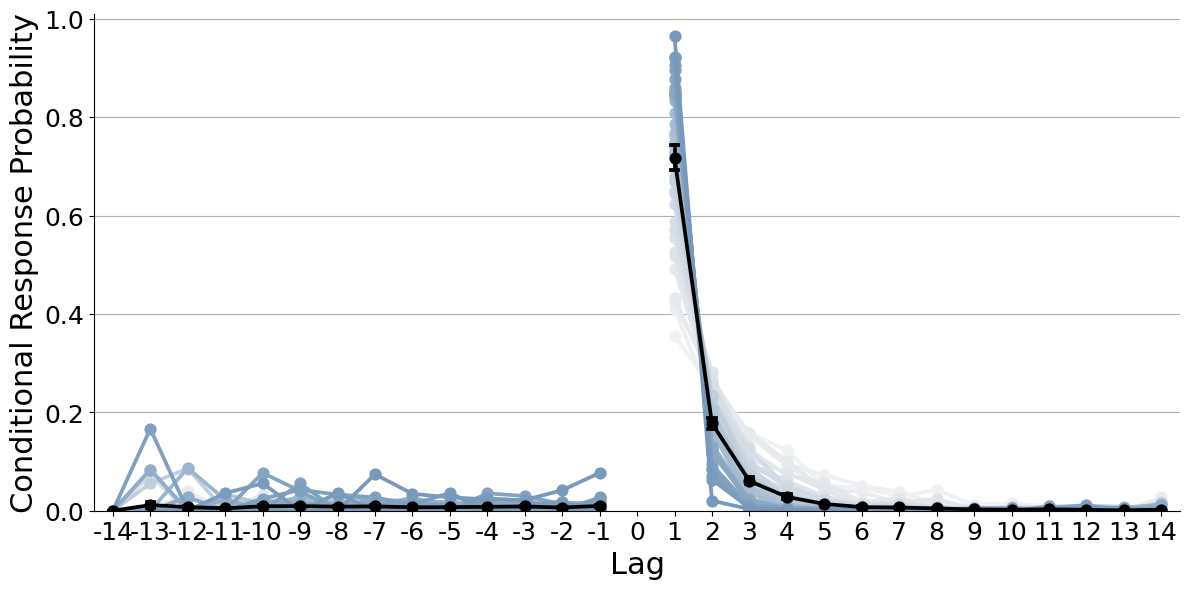

In [21]:
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('white')
ax = plt.gca()

from matplotlib.colors import ListedColormap

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_crp = crp_df.query('subject == @sub')
    sns.pointplot(data=sub_crp, x="lag", y="prob", 
                  color= colors[i], 
                  ax=ax,
                  linestyles="-")

crp = sns.pointplot(data=crp_df, x='lag', y='prob', ci=68,
                    color='k', capsize=.2, ax=ax)

ax.set_xlabel('Lag', fontsize=22)
ax.set_ylabel('Conditional Response Probability', fontsize=22)
ax.tick_params(labelsize=18)
plt.ylim([0,1.01])
ax.yaxis.grid()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.tight_layout()
plt.show()